# Similarity measures

- 2d Kolmogorov-Smirnov test on unaggregated point data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from itertools import pairwise

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ndtest import ks2d2s

from spatial import SpatialUnit, get_force_boundary, map_to_spatial_unit
from utils import (
    CATEGORIES,
    calc_gini,
    extract_crime_data,
    lorenz_curve,
    spearman_rank_correlation_matrix,
    tokenize_force_name,
)

In [16]:
FORCE = "West Yorkshire"
CATEGORY = CATEGORIES[0]  # ASB
OBSERVATION_WINDOW = 3  # months
AREA: SpatialUnit = "STREET"
AREA_PARAMETERS = defaultdict(
    dict,
    {
        "LSOA": {"resolution": "GC"},
        "GRID": {"size": 500.0},
        "HEX": {"resolution": 8},
    },
)

In [17]:
force_boundary = get_force_boundary(FORCE)
raw_crime_data = extract_crime_data(tokenize_force_name(FORCE))
# filter by catgegory and remove any points
raw_crime_data = raw_crime_data[raw_crime_data["Crime type"] == CATEGORY]
raw_crime_data = raw_crime_data[raw_crime_data.geometry.intersects(force_boundary.geometry.union_all())]
raw_crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry
Crime ID,,,,,,,,
1dc7a8dbaf4fe640e89b8f310579cbc9c8e74002a42afec93982fcfeee29e377,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Church Street,E01010646,Bradford 001A,Violence and sexual offences,POINT (408359.006 449659.021)
9512e607ed96486619d9b23702cd3126112730e864d400d4978d1d605b489fc2,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Parking Area,E01010646,Bradford 001A,Violence and sexual offences,POINT (407832.994 449794.972)
fa36558a185e97bfb7748679647801272d0e8b17896ba7ed53f553d7cecc18a2,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Stockinger Lane,E01010647,Bradford 001B,Violence and sexual offences,POINT (407855.984 449587.95)
2e56f481c354bb75f215c171f0f6837360b31732a76b982c90f75a7d9fc22fc0,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Cockshott Place,E01010647,Bradford 001B,Violence and sexual offences,POINT (407350.973 449900.008)
4084e97583165e918586c4d36a599d602740f72eef95be55978f9fbbb1b6532f,2022-05,West Yorkshire Police,West Yorkshire Police,On or near Cockshott Place,E01010647,Bradford 001B,Violence and sexual offences,POINT (407350.973 449900.008)
...,...,...,...,...,...,...,...,...
a8cf6a7848c41fcda8fedb73c7c70408da4a7d2bf41da0a44e40a61b9c51895b,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Grove Way,E01011872,Wakefield 045D,Violence and sexual offences,POINT (444686.999 410596.051)
c1547cb03e3a3e6e0d574bec4af8df310d17a6458a4ecb89c5cbe93d180ad5ed,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Radford Park Avenue,E01011872,Wakefield 045D,Violence and sexual offences,POINT (444593.011 410321.009)
3186127efc7e7b1de2da82f2deefc0924266bd518eff0ce6f37fdb3301aa6f5c,2025-04,West Yorkshire Police,West Yorkshire Police,On or near Clifford Road,E01011872,Wakefield 045D,Violence and sexual offences,POINT (444662.025 410807.995)


2022-05 2022-06 0.2561426415725091
2022-06 2022-07 0.4659742139744317
2022-07 2022-08 0.0006029021528579711
2022-08 2022-09 0.0010153470625392101
2022-09 2022-10 8.459414024038247e-06
2022-10 2022-11 6.544199522617816e-05
2022-11 2022-12 0.003429216988485616
2022-12 2023-01 0.012794805544705473
2023-01 2023-02 0.07153961455875862
2023-02 2023-03 0.0018068090076377064
2023-03 2023-04 5.264448568822736e-06
2023-04 2023-05 0.0028045205427904446
2023-05 2023-06 0.011035070141691406
2023-06 2023-07 7.212892871053665e-06
2023-07 2023-08 0.0004232256450203931
2023-08 2023-09 0.19361805294986517
2023-09 2023-10 3.582699819915033e-05
2023-10 2023-11 0.20660197329686858
2023-11 2023-12 0.15625237144703186
2023-12 2024-01 0.05981410863322443
2024-01 2024-02 0.28456865248558716
2024-02 2024-03 0.005829837606174709
2024-03 2024-04 0.04921142530752049
2024-04 2024-05 3.387803096517559e-05
2024-05 2024-06 9.574280995826413e-05
2024-06 2024-07 0.015965477998002544
2024-07 2024-08 0.0017064944821418727

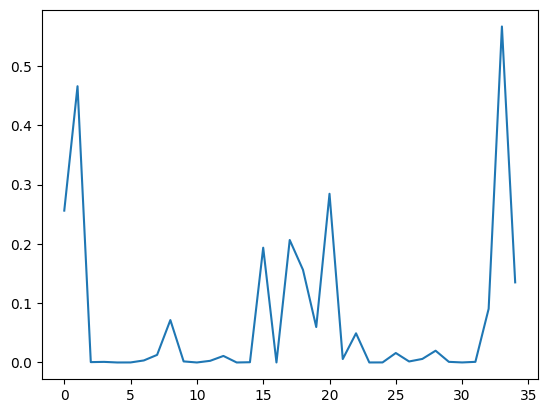

In [15]:
months = sorted(raw_crime_data.Month.unique())
sim_scores = []
for left, right in pairwise(months):
    points_left = raw_crime_data[raw_crime_data.Month == left].geometry
    points_right = raw_crime_data[raw_crime_data.Month == right].geometry

    sim_scores.append(
        ks2d2s(points_left.x.to_numpy(), points_left.y.to_numpy(), points_right.x.to_numpy(), points_right.y.to_numpy())
    )
    print(left, right, sim_scores[-1])

plt.plot(sim_scores)